# Assignment
- Start a clean notebook, or continue with yesterday's assignment notebook.
- Continue to participate in our Kaggle competition with the Tanzania Waterpumps data. 
- Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- Try a Decision Tree Classifier. 
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- Create visualizations and share on Slack.
- Read more about decision trees and tree ensembles. You can start with the links at the top of this notebook.
- Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [40]:
# Importing data and doing train/val split on time...

import pandas as pd
from sklearn.model_selection import train_test_split

LOCAL = '../data/tanzania/'

train = pd.merge(pd.read_csv(LOCAL + 'train_features.csv'),
                 pd.read_csv(LOCAL + 'train_labels.csv'))
test = pd.read_csv(LOCAL + 'test_features.csv')
sample_submission = pd.read_csv(LOCAL + 'sample_submission.csv')

train['date_recorded'] = pd.to_datetime(train['date_recorded'], 
                                        infer_datetime_format=True)

split = train['date_recorded'].quantile(.8)
val = train[train['date_recorded'] > split]
train = train[train['date_recorded'] <= split]

train.shape, val.shape, test.shape

((47553, 41), (11847, 41), (14358, 40))

In [41]:
# Exploring train data...

import pandas_profiling

#train.profile_report()

In [42]:
# Wrangling data...

import numpy as np

def wrangle(data):
    """Wrangles train, validate, and test sets in the same way"""
    data = data.copy()
    
    # When latitude has small values near zero outside Tanzania, 
    # treating these values like zero...
    data['latitude'] = data['latitude'].replace(-2e-08, 0)
    
    # Encoding boolean features as ordinals...
    cols_with_bools = ['public_meeting',
                       'permit']
    for col in cols_with_bools:
        data[col] = data[col].replace({True: 1, False: 0})
        
    # Replacing zeros used to represent nulls with actual nulls...
    cols_with_zeros = ['construction_year',
                       'longitude',
                       'latitude',
                       'amount_tsh',
                       'gps_height',
                       'population',
                       'public_meeting',
                       'permit']
    for col in cols_with_zeros:
        data[col] = data[col].replace(0, np.nan)
        data[col] = data[col].fillna(data[col].mean())
            
    # Dropping single value, duplicate, and redundant columns...
    cols_to_drop = ['recorded_by',
                    'quantity_group',
                    'num_private',
                    'waterpoint_type_group',
                    'payment_type',
                    'source_type',
                    'quality_group',
                    'source_class',
                    'management_group',
                    'scheme_management',
                    'extraction_type_class',
                    'extraction_type_group']
    for col in cols_to_drop:
        data = data.drop(columns=col)
    
    return data

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [43]:
# Selecting features...

target = 'status_group'

# Since we don't want to use the target or id as features...
train_features = train.drop(columns=[target, 'id'])

# Getting numeric features...
numeric_features = train_features.select_dtypes(
    include='number').columns.tolist()

# Getting categorical features with cardinality <= 25...
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 25].index.tolist()

# Combining lists of numeric and categorical features...
features = numeric_features + categorical_features

Train Accuracy Score: 0.7349273442264421
Validation Accuracy Score: 0.7310711572550013


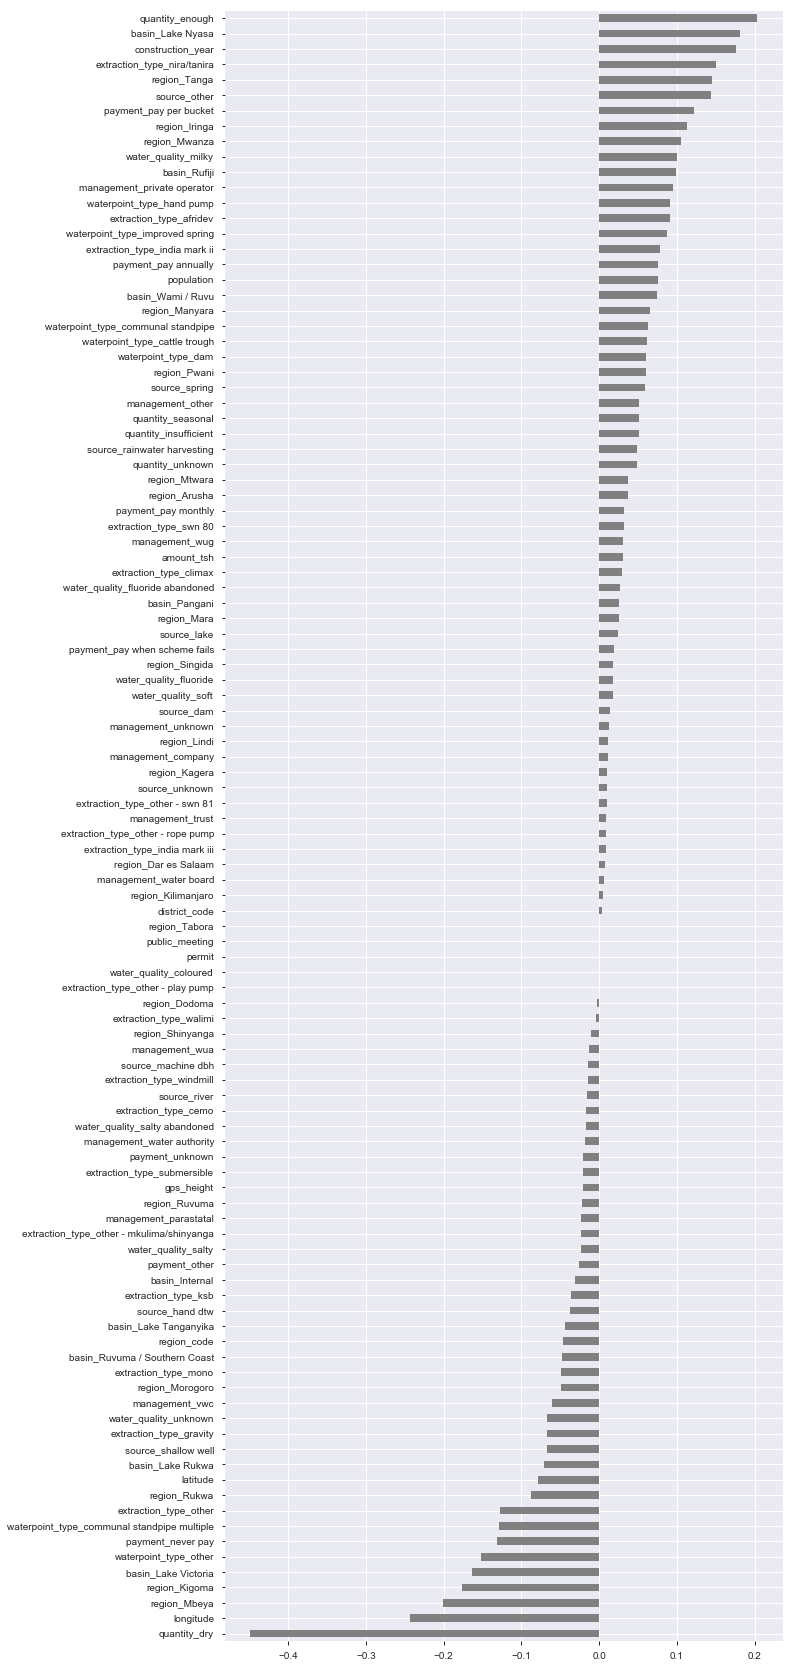

In [44]:
# Using a logistic regression and getting accuracy and coefficients...

import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Arranging data into X features matrix and y target vector ...
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# One-Hot Encoding categorical features...
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaling data...
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Fitting model on train data, scoring accuracy, predicting on test data...
model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting coefficients...
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns.tolist())
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

Train Accuracy Score: 0.7194078186444599
Validation Accuracy Score: 0.7251624883936861


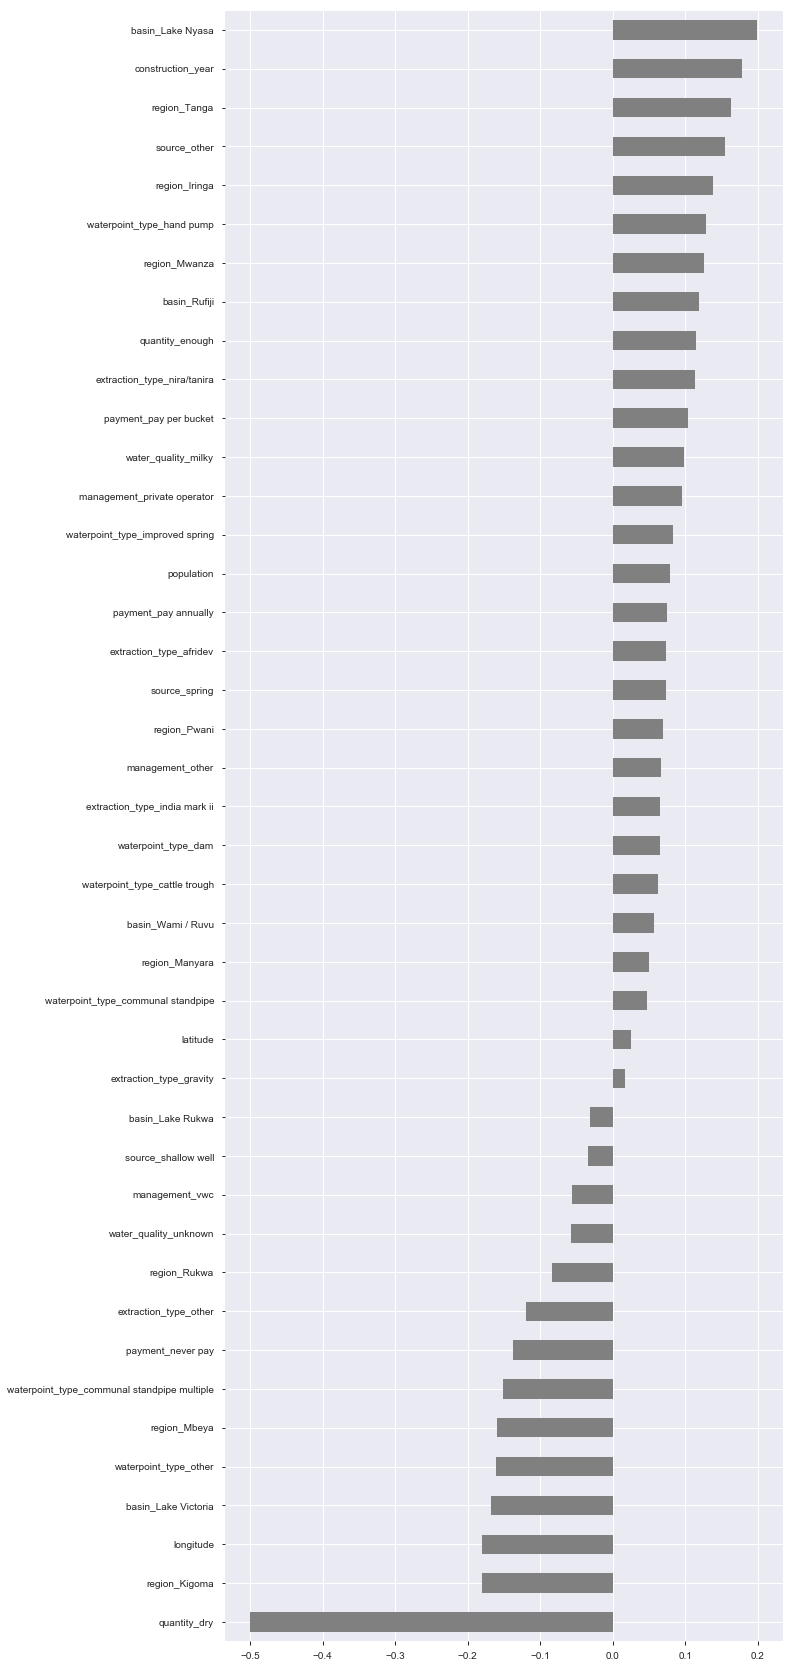

In [45]:
# Logistic regression using only features with absolute coefs in top 40%...

# Finding features with absolute coefs in top 40%...
coef_df = pd.DataFrame(model.coef_[0],
                       index=X_train_encoded.columns.tolist())
coef_df['abs_coef'] = coef_df[0].abs()
high_coef_features = coef_df[
    coef_df['abs_coef'] > coef_df['abs_coef'].quantile(.60)].index.tolist()

# Scaling data containing only features with absolute coefs in top 40%...
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded[high_coef_features])
X_val_scaled = scaler.transform(X_val_encoded[high_coef_features])
X_test_scaled = scaler.transform(X_test_encoded[high_coef_features])

# Fitting model on train data, scoring accuracy, predicting on test data...
model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting coefficients...
coefficients = pd.Series(model.coef_[0], high_coef_features)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

Train Accuracy Score: 0.7269993480958089
Validation Accuracy Score: 0.7078585295855491


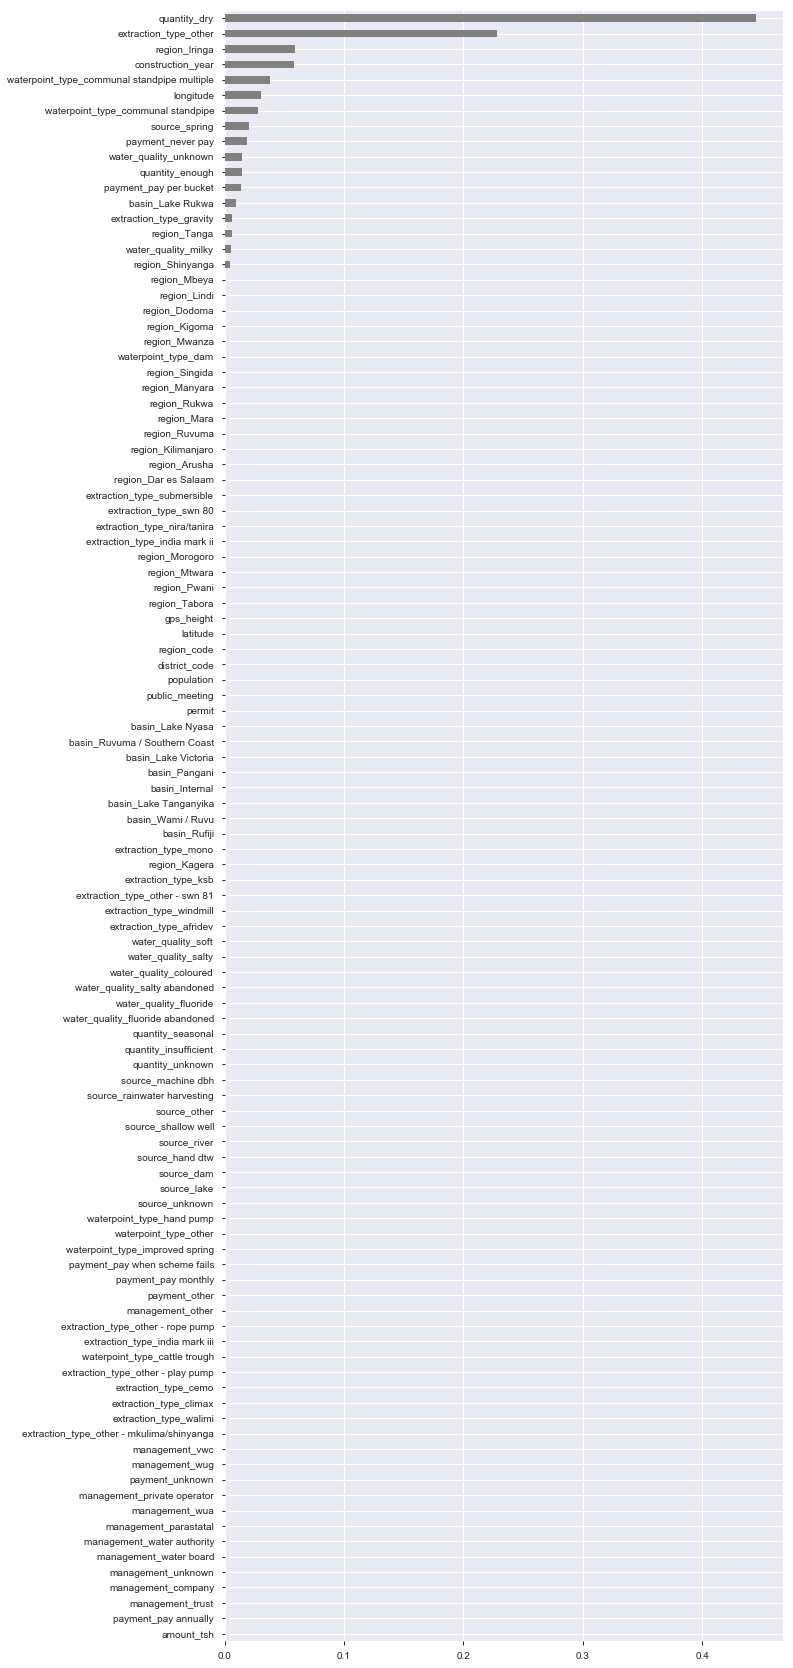

In [46]:
# Using a decision tree classifier and getting accuracy and importances...

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler

# Scaling data...
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Fitting model on train data, scoring accuracy, predicting on test data...
model = DecisionTreeClassifier(max_depth=8, max_leaf_nodes=24)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting feature importances...
importances = pd.Series(model.feature_importances_,
                        X_train_encoded.columns.tolist())
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

Train Accuracy Score: 0.7313523857590478
Validation Accuracy Score: 0.7064235671478011


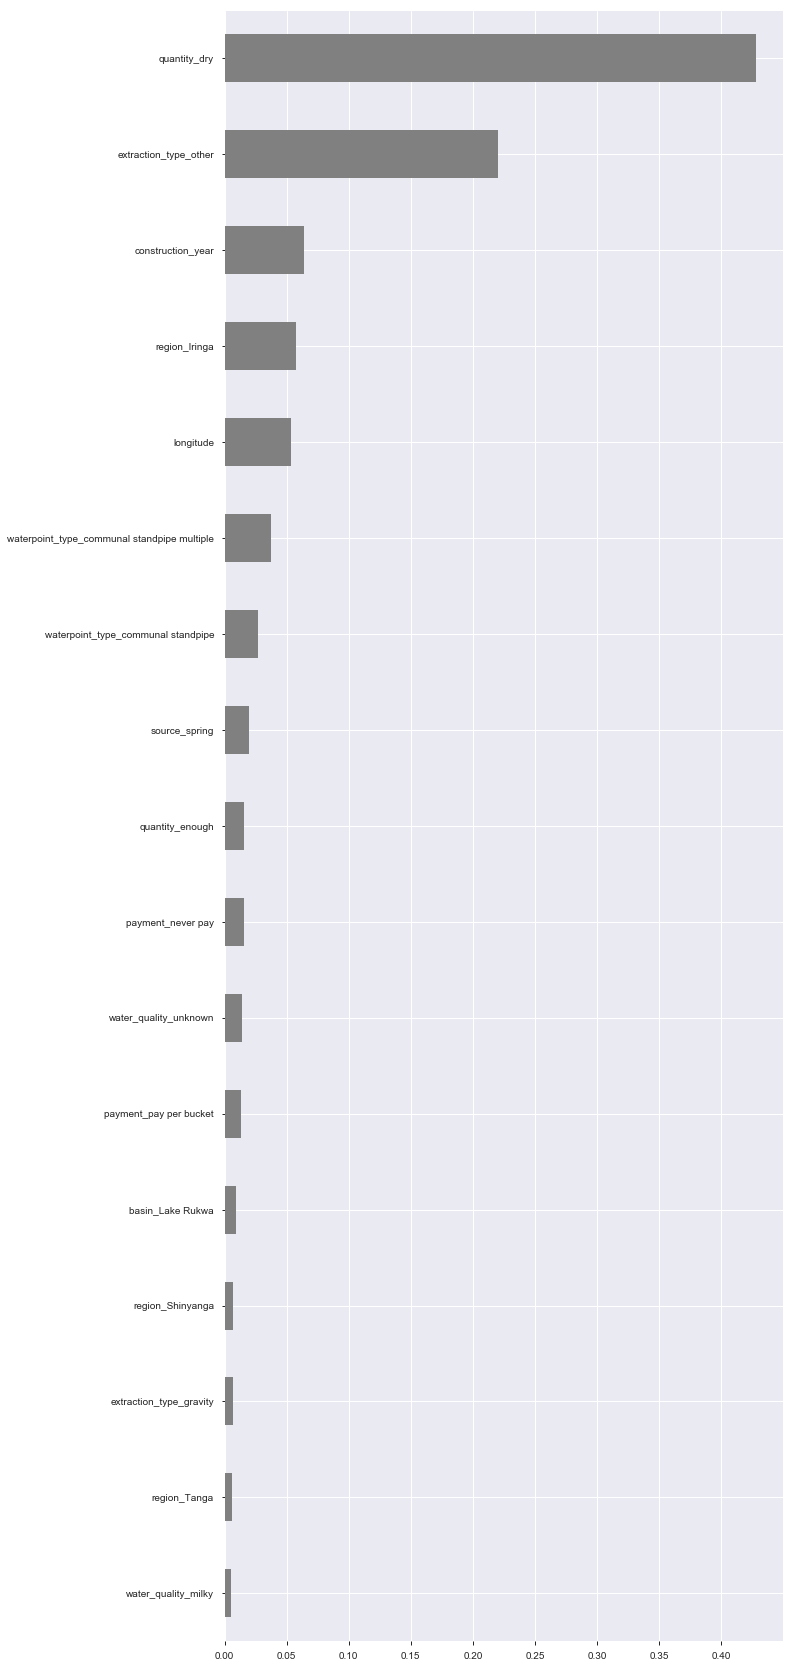

In [47]:
# Decision tree classifier using only features with non-zero importance...

# Finding features with non-zero importance...
importances_df = pd.DataFrame(model.feature_importances_,
                              index=X_train_encoded.columns.tolist())
important_features = importances_df[importances_df[0] > 0].index.tolist()

# Scaling data containing only important features...
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded[important_features])
X_val_scaled = scaler.transform(X_val_encoded[important_features])
X_test_scaled = scaler.transform(X_test_encoded[important_features])

# Fitting model on train data, scoring accuracy, predicting on test data...
model = DecisionTreeClassifier(max_depth=7, max_leaf_nodes=74)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting feature importances...
importances = pd.Series(model.feature_importances_, important_features)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

Train Accuracy Score: 0.9943221247870797
Validation Accuracy Score: 0.743479361863763


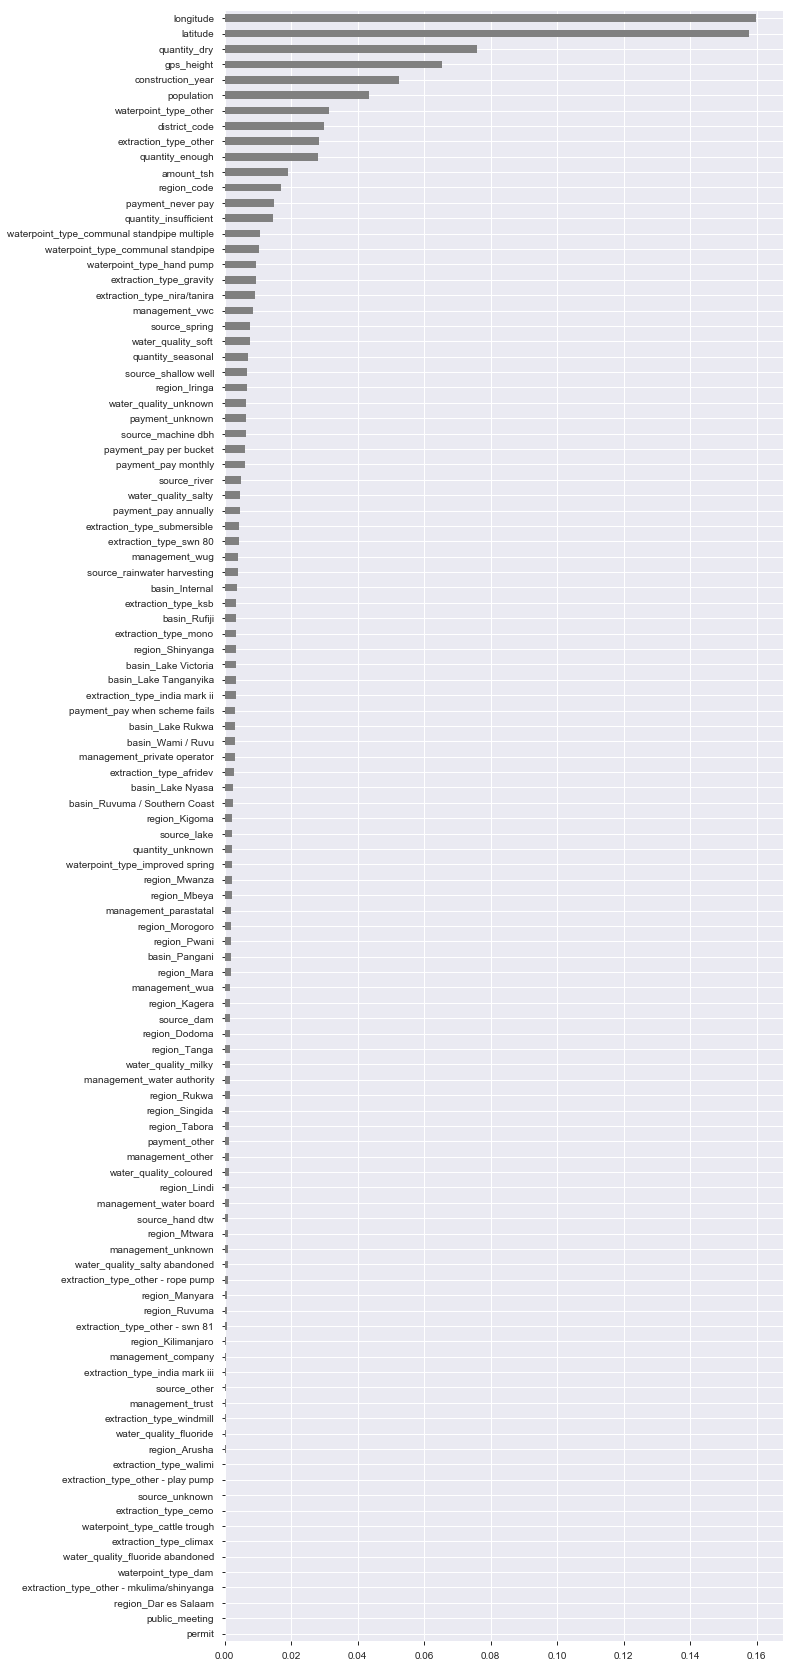

In [49]:
# Using a random forest classifier and getting accuracy and importances...

from sklearn.ensemble import RandomForestClassifier

# Scaling data...
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Fitting model on train data, scoring accuracy, predicting on test data...
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting feature importances...
importances = pd.Series(model.feature_importances_,
                        X_train_encoded.columns.tolist())
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [ ]:
# Random forest classifier using only features with non-zero importance...

# Finding features with non-zero importance...
importances_df = pd.DataFrame(model.feature_importances_,
                              index=X_train_encoded.columns.tolist())
important_features = importances_df[importances_df[0] > 0].index.tolist()

# Scaling data containing only important features...
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded[important_features])
X_val_scaled = scaler.transform(X_val_encoded[important_features])
X_test_scaled = scaler.transform(X_test_encoded[important_features])

# Fitting model on train data, scoring accuracy, predicting on test data...
model = DecisionTreeClassifier(max_depth=7, max_leaf_nodes=74)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting feature importances...
importances = pd.Series(model.feature_importances_, important_features)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [ ]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('nathan_van_wyck_submission.csv', index=False)